## Exploratory Data Analysis 

In this script, we will explore the dataset to understand the different information available: expression matrix, sample metadata and gene annotations, and choose our focus points for the analysis. The data from low grade gliomas (LGG) and glioblastoma multiforme (GBM) was previously preprocessed and merged. 

### Data loading 

In [1]:
import pandas as pd
import numpy as np
import pyreadr
import json
import matplotlib.pyplot as plt

In [2]:
#load expression, genes and samples data
expression=pd.read_csv("../data/merged_expression.csv", index_col=0)
genes=pd.read_csv("../data/merged_genes.csv", index_col=0)
samples = pyreadr.read_r("../data/merged_samples.rds")
    

In [3]:
#extract the dataframe from the sample metadata dictionary 
key = next(iter(samples.keys()))
samples = samples[key]
print(type(samples))


<class 'pandas.core.frame.DataFrame'>


### Exploring the sample metadata 

We want to understand the different clinical information at our disposal, as well as the other covariates that could be used in the analysis. 

In [4]:
print(samples.head())
print(samples.shape)

# list of column names
samples.columns.tolist()


                                                   barcode       patient  \
rownames                                                                   
TCGA-HT-7468-01A-11R-2027-07  TCGA-HT-7468-01A-11R-2027-07  TCGA-HT-7468   
TCGA-DU-7015-01A-11R-2027-07  TCGA-DU-7015-01A-11R-2027-07  TCGA-DU-7015   
TCGA-HT-7601-01A-11R-2090-07  TCGA-HT-7601-01A-11R-2090-07  TCGA-HT-7601   
TCGA-DU-A6S7-01A-21R-A32Q-07  TCGA-DU-A6S7-01A-21R-A32Q-07  TCGA-DU-A6S7   
TCGA-IK-7675-01A-11R-2090-07  TCGA-IK-7675-01A-11R-2090-07  TCGA-IK-7675   

                                        sample shortLetterCode  \
rownames                                                         
TCGA-HT-7468-01A-11R-2027-07  TCGA-HT-7468-01A              TP   
TCGA-DU-7015-01A-11R-2027-07  TCGA-DU-7015-01A              TP   
TCGA-HT-7601-01A-11R-2090-07  TCGA-HT-7601-01A              TP   
TCGA-DU-A6S7-01A-21R-A32Q-07  TCGA-DU-A6S7-01A              TP   
TCGA-IK-7675-01A-11R-2090-07  TCGA-IK-7675-01A              TP   

    

['barcode',
 'patient',
 'sample',
 'shortLetterCode',
 'definition',
 'sample_submitter_id',
 'intermediate_dimension',
 'tumor_descriptor',
 'sample_id',
 'pathology_report_uuid',
 'submitter_id',
 'shortest_dimension',
 'sample_type',
 'specimen_type',
 'longest_dimension',
 'days_to_collection',
 'state',
 'initial_weight',
 'tissue_type',
 'preservation_method',
 'synchronous_malignancy',
 'supratentorial_localization',
 'days_to_diagnosis',
 'laterality',
 'treatments',
 'tissue_or_organ_of_origin',
 'days_to_last_follow_up',
 'age_at_diagnosis',
 'primary_diagnosis',
 'prior_malignancy',
 'year_of_diagnosis',
 'prior_treatment',
 'diagnosis_is_primary_disease',
 'morphology',
 'first_symptom_longest_duration',
 'classification_of_tumor',
 'diagnosis_id',
 'icd_10_code',
 'site_of_resection_or_biopsy',
 'first_symptom_prior_to_diagnosis',
 'tumor_grade',
 'sites_of_involvement',
 'tumor_of_origin',
 'race',
 'gender',
 'ethnicity',
 'vital_status',
 'age_at_index',
 'days_to_birt

In [5]:
# seeing whether rows represent unique patients or whether some patients have undergone several sequencing events
print(len(samples["submitter_id"]))
print(len(samples["submitter_id"].unique()))

925
809


In [6]:
# understanding which clinical data is shared for all patients 
samples_na = samples.isna().sum()
print(samples_na)

print(samples_na[samples_na == 0].index) # seeing which columns have 0 NAs

barcode                                                  0
patient                                                  0
sample                                                   0
shortLetterCode                                          0
definition                                               0
                                                      ... 
paper_RPPA.cluster                                     507
paper_Telomere.length.estimate.in.blood.normal..Kb.    770
paper_Telomere.length.estimate.in.tumor..Kb.           772
tumor_type                                               0
method_of_diagnosis                                    679
Length: 114, dtype: int64
Index(['barcode', 'patient', 'sample', 'shortLetterCode', 'definition',
       'sample_submitter_id', 'tumor_descriptor', 'sample_id', 'submitter_id',
       'sample_type', 'specimen_type', 'state', 'tissue_type',
       'preservation_method', 'treatments', 'bcr_patient_barcode',
       'primary_site', 'project_id', 'diseas

In [7]:
# understanding the different types of clinical information available
patterns = {
    "survival_or_time": ["days", "death", "follow", "surviv", "vital", "progress", "recurr"],
    "demographics": ["age", "gender", "sex", "race", "ethnic"],
    "tumor_clinical": ["grade", "stage", "diagnos", "tumor", "histolog", "subtype", "idh", "mgmt"],
    "treatment": ["therapy", "radiat", "chemo", "temoz", "treatment", "drug"],
    "technical_batch": ["center", "plate", "batch", "analyte", "aliquot", "portion", "tss"],
}

for group, keys in patterns.items():
    hits = [c for c in samples.columns if any(k in c.lower() for k in keys)]
    print(group, "->", hits[:30])


survival_or_time -> ['days_to_collection', 'days_to_diagnosis', 'days_to_last_follow_up', 'vital_status', 'days_to_birth', 'cause_of_death', 'days_to_death', 'paper_Survival..months.', 'paper_Vital.status..1.dead.']
demographics -> ['age_at_diagnosis', 'race', 'gender', 'ethnicity', 'age_at_index', 'age_is_obfuscated', 'paper_Age..years.at.diagnosis.', 'paper_Gender']
tumor_clinical -> ['tumor_descriptor', 'days_to_diagnosis', 'age_at_diagnosis', 'primary_diagnosis', 'year_of_diagnosis', 'diagnosis_is_primary_disease', 'classification_of_tumor', 'diagnosis_id', 'first_symptom_prior_to_diagnosis', 'tumor_grade', 'tumor_of_origin', 'paper_Histology', 'paper_Grade', 'paper_Age..years.at.diagnosis.', 'paper_IDH.status', 'paper_IDH.codel.subtype', 'paper_MGMT.promoter.status', 'paper_Original.Subtype', 'paper_Transcriptome.Subtype', 'paper_IDH.specific.RNA.Expression.Cluster', 'paper_IDH.specific.DNA.Methylation.Cluster', 'paper_Telomere.length.estimate.in.tumor..Kb.', 'tumor_type', 'method

In [8]:
# looking into more details about clinical information of interest
print(samples["primary_diagnosis"].value_counts())
print(samples["tumor_grade"].value_counts())
print(samples["tumor_type"].value_counts())
print(samples["gender"].value_counts())
print(pd.to_numeric(samples["age_at_diagnosis"], errors="coerce").describe())

primary_diagnosis
Glioblastoma                     376
Mixed glioma                     128
Oligodendroglioma, NOS           114
Astrocytoma, anaplastic          110
Oligodendroglioma, anaplastic     73
Astrocytoma, NOS                  58
Not Reported                      49
Unknown                            9
Papillary carcinoma, NOS           1
Basal cell carcinoma, NOS          1
Name: count, dtype: int64
tumor_grade
G4    391
G3    216
G2    211
Name: count, dtype: int64
tumor_type
LGG    534
GBM    391
Name: count, dtype: int64
gender
male            536
female          382
not reported      1
Name: count, dtype: int64
count      895.000000
mean     18271.487151
std       5703.778314
min       5267.000000
25%      13550.000000
50%      18376.000000
75%      22610.500000
max      32612.000000
Name: age_at_diagnosis, dtype: float64


### Expression matrix 

We now explore the expression count matrix, understanding the number of patients profiled, the total number of genes, the mean expression per sample/gene... 

In [9]:
print(expression.head())
print(expression.shape)

                              ENSG00000276168.1  ENSG00000263740.2  \
TCGA-HT-7468-01A-11R-2027-07           8.604286           5.563223   
TCGA-DU-7015-01A-11R-2027-07           8.453606           5.546896   
TCGA-HT-7601-01A-11R-2090-07           9.694192           5.479652   
TCGA-DU-A6S7-01A-21R-A32Q-07           8.322266           5.563448   
TCGA-IK-7675-01A-11R-2090-07           8.279067           5.604416   

                              ENSG00000133048.13  ENSG00000265735.2  \
TCGA-HT-7468-01A-11R-2027-07            7.809334           5.075322   
TCGA-DU-7015-01A-11R-2027-07            8.858111           5.546896   
TCGA-HT-7601-01A-11R-2090-07           11.204155           5.596186   
TCGA-DU-A6S7-01A-21R-A32Q-07            7.701043           5.075322   
TCGA-IK-7675-01A-11R-2090-07            8.531655           5.450490   

                              ENSG00000202058.1  ENSG00000198695.2  \
TCGA-HT-7468-01A-11R-2027-07           6.060727          15.949436   
TCGA-DU-7015

Summary — mean expression per gene: count    2000.000000
mean        9.310474
std         1.962580
min         5.746409
25%         7.879563
50%         9.068226
75%        10.500355
max        19.287780
dtype: float64


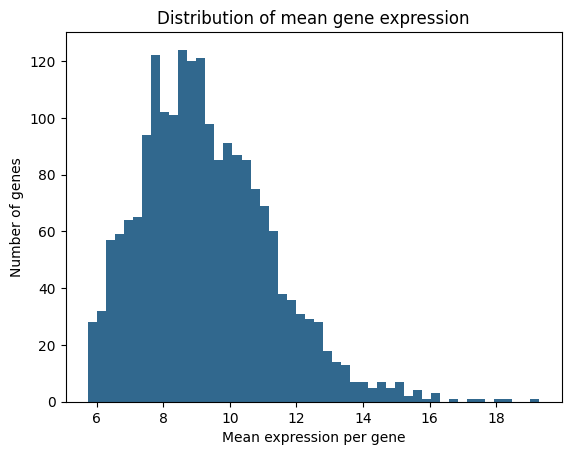

In [10]:
# mean expression per gene
gene_mean = expression.mean(axis=0)

print("Summary — mean expression per gene:", gene_mean.describe())

plt.figure()
plt.hist(gene_mean, bins=50, color="#31688E")
plt.xlabel("Mean expression per gene")
plt.ylabel("Number of genes")
plt.title("Distribution of mean gene expression")
plt.show()


Summary — total expression per sample:
count      925.000000
mean     18620.948251
std        668.877836
min      16385.192662
25%      18162.224261
50%      18582.524206
75%      19030.289300
max      20581.626542
dtype: float64


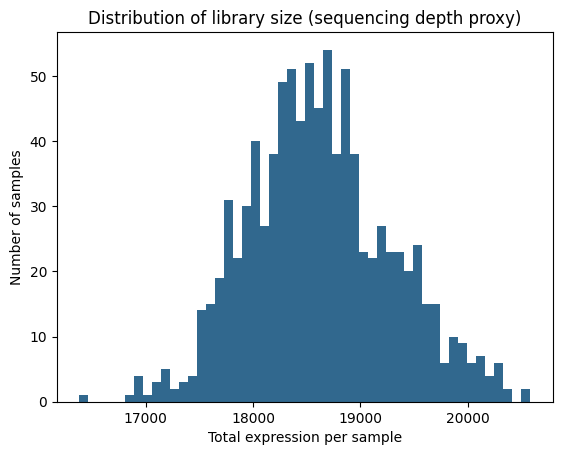

In [11]:
# total expression per sample (proxy for sequencing depth)
sample_sum = expression.sum(axis=1)

print("Summary — total expression per sample:")
print(sample_sum.describe())

plt.figure()
plt.hist(sample_sum, bins=50, color="#31688E")
plt.xlabel("Total expression per sample")
plt.ylabel("Number of samples")
plt.title("Distribution of library size (sequencing depth proxy)")
plt.show()


### Gene annotations

Finally, we visualise which information is contained in the gene annotations dataframe. 

In [12]:
print(genes.shape)
genes.head()

(60660, 10)


,source,type,score,phase,gene_id,gene_type,gene_name,level,hgnc_id,havana_gene
1,HAVANA,gene,NaN,NaN,ENSG00000000003.15,protein_coding,TSPAN6,2,HGNC:11858,OTTHUMG00000022002.2
2,HAVANA,gene,NaN,NaN,ENSG00000000005.6,protein_coding,TNMD,2,HGNC:17757,OTTHUMG00000022001.2
3,HAVANA,gene,NaN,NaN,ENSG00000000419.13,protein_coding,DPM1,2,HGNC:3005,OTTHUMG00000032742.2
4,HAVANA,gene,NaN,NaN,ENSG00000000457.14,protein_coding,SCYL3,2,HGNC:19285,OTTHUMG00000035941.6
5,HAVANA,gene,NaN,NaN,ENSG00000000460.17,protein_coding,C1orf112,2,HGNC:25565,OTTHUMG00000035821.9
